### 平均地価との差分等を加えていく

In [256]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.stats import norm, skew
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import matplotlib

pd.set_option('max_columns',1000)
pd.set_option('max_rows',1000)

import warnings
warnings.filterwarnings('ignore')

import re
import geocoder
from geopy.distance import great_circle, vincenty
from tqdm import tqdm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import os
import gc
import lightgbm as lgb
from sklearn.model_selection import KFold, train_test_split
from time import time
import datetime
from script import RegressionPredictor,LogRegressionPredictor
import japanize_matplotlib
# print(os.listdir("././input"))
# print(os.listdir("././submit"))
from utils import save_data
SEED=1234
n_splits=10

In [261]:
train=pd.read_csv('./input/prep_train1102.csv')
test=pd.read_csv('./input/prep_test1102.csv')
y_train = train['賃料']

In [258]:
folder=KFold(n_splits=10, shuffle=True, random_state=42)

In [274]:
# train.to_csv('./input/prep_train1102.csv',index=None)
# test.to_csv('./input/prep_test1102.csv',index=None)

In [266]:
# X = X_train[['loc_lat','loc_lon']]
# X2= X_test[['loc_lat','loc_lon']]

# Z=pd.concat([X,X2],axis=0)
# from sklearn.cluster import KMeans
# pred = KMeans(n_clusters=300).fit_predict(Z)
train['km_type']=pred[:train.shape[0]]
test['km_type']=pred[train.shape[0]:]

In [275]:
drop_col = ['id']

## 必要な特徴量に絞る
y_train = train['賃料']
y_train_log = np.log1p(y_train)
X_train = train.drop(drop_col,axis=1)
X_test = test.drop(drop_col,axis=1)

In [276]:
X_train['地価']=X_train['賃料']/X_train['面積']

In [277]:
def feature_encoding(train, test, category_col, target_col, func_list):
    '''target_encodingを重要な列（面積など）でやる。TEと違って、test_dfに含まれる値も集計して作る'''
    data=pd.concat([train,test],axis=0).reset_index()
    
    agg_func = {target_col: func_list}
    #agg_funcでgruopby
    agg_df = data.groupby(category_col)[target_col].agg(agg_func)
    #列名作成
    agg_df.columns = [category_col + '_' + '_'.join(col).strip() for col in agg_df.columns.values]
    #元の列に集約結果をmapしその値をコピーし新規列に加え返す。
    for col in agg_df.columns.values:
        train[col] = train[category_col].map(agg_df[col]).copy()
        test[col] = test[category_col].map(agg_df[col]).copy()
    return train, test

### target_encoding

In [279]:
def target_encoding(train, test, category_col, target_col, func_list):
    
    agg_func = {target_col: func_list}
    #agg_funcでgruopby
    agg_df = train.groupby(category_col)[target_col].agg(agg_func)
    #列名作成
    agg_df.columns = [category_col + '_' + '_'.join(col).strip() for col in agg_df.columns.values]
    #元の列に集約結果をmapしその値をコピーし新規列に加え返す。
    for col in agg_df.columns.values:
        train[col] = train[category_col].map(agg_df[col]).copy()
        test[col] = test[category_col].map(agg_df[col]).copy()
    return train, test


category_col='km_type'

target_dict = {category_col: ['mean']}
target_col = '地価'
for category_col, func_list in target_dict.items():
    X_train, X_test = feature_encoding(X_train, X_test, category_col, target_col, func_list)

X_train['地価x面積'] = X_train['面積'] * X_train[f'{category_col}_地価_mean']
X_test['地価x面積'] = X_test['面積'] * X_test[f'{category_col}_地価_mean']

### feature_encoding

In [280]:

X_train['地価'] = X_train['賃料'] / X_train['面積']
target_dict = {category_col: ['mean']}
target_col = '面積'
for category_col, func_list in target_dict.items():
    X_train, X_test = feature_encoding(X_train, X_test, category_col, target_col, func_list)

X_train['area_diff'] = X_train['面積'] - X_train[f'{category_col}_面積_mean']
X_train['area_ratio'] = X_train['面積'] / X_train[f'{category_col}_面積_mean']
X_test['area_diff'] = X_test['面積'] - X_test[f'{category_col}_面積_mean']
X_test['area_ratio'] = X_test['面積'] / X_test[f'{category_col}_面積_mean']

target_dict = {category_col: ['mean']}
target_col = '築年数'
for category_col, func_list in target_dict.items():
    X_train, X_test = feature_encoding(X_train, X_test, category_col, target_col, func_list)

X_train['age_diff'] = X_train['築年数'] - X_train[f'{category_col}_築年数_mean']
X_train['age_ratio'] = X_train['築年数'] / X_train[f'{category_col}_築年数_mean']
X_test['age_diff'] = X_test['築年数'] - X_test[f'{category_col}_築年数_mean']
X_test['age_ratio'] = X_test['築年数'] / X_test[f'{category_col}_築年数_mean']
X_train['area/ageratio'] = X_train['area_ratio'] / X_train['age_ratio']
X_test['area/ageratio'] = X_test['area_ratio'] / X_test['age_ratio']

X_train['地価x面積'] = X_train['面積'] * X_train[f'{category_col}_地価_mean']
X_test['地価x面積'] = X_test['面積'] * X_test[f'{category_col}_地価_mean']
X_train['地価x面積/築年数ratio'] = X_train['地価x面積'] / X_train['age_ratio']
X_test['地価x面積/築年数ratio'] = X_test['地価x面積'] / X_test['age_ratio']


In [281]:
X_train.columns

Index(['契約期間', '建物構造', '所在階', '方角', '築年数', '賃料', '間取り', '面積', '駐車場', '共同バス',
       ...
       'km_type_地価_mean', '地価x面積', 'km_type_面積_mean', 'area_diff',
       'area_ratio', 'km_type_築年数_mean', 'age_diff', 'age_ratio',
       'area/ageratio', '地価x面積/築年数ratio'],
      dtype='object', length=212)

In [240]:
# def get_loc_type(data,out_col='loc_type'):
#     '''緯度経度による、グリッドを作成'''
#     data2=data.copy()
#     data2[out_col]=0
#     count=0
#     for i in range(1,12):
#         for j in range(11):
#             data2.loc[data2.query(f'139.56+{i*0.03}<loc_lon<139.56+{(i+1)*0.03}&35.53+{j*0.03}<loc_lat<35.53+{(j+i)*0.03}').index.values,out_col]=count
#             print(count,end='')
#             print(data2.query(f'139.56+{i*0.03}<loc_lon<139.56+{(i+1)*0.03}&35.53+{j*0.03}<loc_lat<35.53+{(j+i)*0.03}').index.shape)
#             count+=1
#     return data2

# X_train['loc_type']=get_loc_type(X_train)
# X_test['loc_type']=get_loc_type(X_test)

In [241]:
# train['loc_type']
# sns.factorplot('Pclass','Survived',hue='Sex',data=train)

In [242]:
# loc_df=pd.DataFrame()
# loc_df['train']=train['loc_type'].value_counts()
# loc_df['test']=test['loc_type'].value_counts()
# loc_df.plot.scatter(0,1)
# plt.title('trainとtestのloc_typeの分布が同じことを確認')
# plt.show()


### make clusuter

In [158]:
# X = X_train[['loc_lat','loc_lon']]

# from sklearn.cluster import KMeans
# pred = KMeans(n_clusters=300).fit_predict(X)
# X['cluster'] = pred

In [243]:
# def plot_scatter(oof,train_y):
#     print('RMSE : ', np.sqrt(mean_squared_error(oof,train_y)))
#     print('R^2 : ', r2_score(oof,train_y))
#     plt.figure()
#     plt.scatter(oof,train_y, alpha=0.7)
#     plt.title("$R^2 = {:<.5}$".format(r2_score(oof,train_y)))
#     x = np.linspace(0, 2500000, 100)
#     plt.plot(x, x, c="indianred")
#     plt.xlabel('predict', size=20)
#     plt.ylabel('correct', size=20)
#     plt.show()
# plot_scatter(X_train['地価x面積'],y_train)

In [244]:
lgbm_params = {
    'num_iterations': 50000,
    'learning_rate': 0.01,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'reg_lambda': 68.19849585036235,
    'reg_alpha': 0.007585940082730346,
    'colsample_bytree': 0.6,
    'subsample': 0.5,
    'max_depth': 8,
    'min_child_weight': 8,
    'lambda': 1,
    'eta': 0.1,
    'verbose': 1,
    'random_state': 0,
    'early_stopping_round': 50
    }

lgbm_log_params=lgbm_params.copy()
lgbm_log_params['metric']='mae'
lgbm_log_params['learning_rate']=0.05

lgbm_x_params=lgbm_params.copy()
lgbm_x_params['metric']='cross_entropy'
lgbm_x_params['learning_rate']=0.05


### xent_predict

In [282]:
# features =  ['面積','築年数','sta_min','center_dis','L','loc_lat','loc_lon','総階数','畳','所在階','loc_type_地価_mean',
#              '地価x面積', 'area_diff','area_ratio', 'age_diff', 'age_ratio','area/ageratio', '地価x面積/築年数ratio']

features =  ['面積','築年数','sta_min','center_dis','L','loc_lat','loc_lon','総階数','畳','所在階','km_type_地価_mean', '地価x面積', 'area_diff',
       'area_ratio', 'age_diff', 'age_ratio',
       'area/ageratio', '地価x面積/築年数ratio']
X_train = X_train[features]
X_test = X_test[features]

In [283]:
class TERegressionPredictor(RegressionPredictor):
    '''学習時に目的変数を変換するときに使う。例えばlogを取ってから学習する場合など。
         revertには逆操作となる関数を定義する。    
    '''
    def __init__(self, train_X, train_y, test_X, params=None, Folder=None, sk_model=None, n_splits=5, clf_type='xgb', aggfunc_dict=None, verbose_eval=5000, func=np.log1p, revert_func=np.expm1):
        self.func=func
        self.revert_func=revert_func
        super(LogRegressionPredictor, self).__init__(train_X, self.func(train_y), test_X, params,
                                                     Folder, sk_model, n_splits, clf_type, aggfunc_dict, verbose_eval)
    def target_encoding(self, tr_X, val_X, tr_y):
        '''CVとTEのfoldを同じにした。
        test,valのTEはtr_Xの情報のみで作られる。
        self.testが更新されるが、毎回のCVで上書きされる
        TODO:後からTEを取り出せるようにする。
        '''
        tr_X['target'] = tr_y
        for category_col, func_list in self.aggfunc_dict.items():
            agg_func = {'target': func_list}
            #agg_funcでgruopby
            agg_df = tr_X.groupby(category_col)['target'].agg(agg_func)
            #列名作成
            agg_df.columns = [category_col + '_' + '_'.join(col).strip() for col in agg_df.columns.values]

            #元の列に集約結果をmapしその値をコピーし新規列に加え返す。
            #列名を追加する。
            if not set(agg_df.columns.values).issubset(set(self.columns)):
                self.columns = np.append(self.columns, agg_df.columns.values)
            for col in agg_df.columns.values:
                tr_X[col] = tr_X[category_col].map(agg_df[col]).copy()
                val_X[col] = val_X[category_col].map(agg_df[col]).copy()
                self.test_X[col] = self.test_X[category_col].map(agg_df[col]).copy()
        tr_X.drop(columns='target', inplace=True)
        return tr_X, val_X

Training on fold 1
Training until validation scores don't improve for 50 rounds.
[5000]	training's xentropy: 0.517649	valid_1's xentropy: 0.51855
Early stopping, best iteration is:
[5849]	training's xentropy: 0.517646	valid_1's xentropy: 0.518549
Training on fold 2
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[4372]	training's xentropy: 0.517619	valid_1's xentropy: 0.518855
Training on fold 3
Training until validation scores don't improve for 50 rounds.
[5000]	training's xentropy: 0.517765	valid_1's xentropy: 0.51752
Early stopping, best iteration is:
[6540]	training's xentropy: 0.51776	valid_1's xentropy: 0.517518
Training on fold 4
Training until validation scores don't improve for 50 rounds.
[5000]	training's xentropy: 0.517816	valid_1's xentropy: 0.517052
Early stopping, best iteration is:
[5466]	training's xentropy: 0.517815	valid_1's xentropy: 0.517051
Training on fold 5
Training until validation scores don't improve for 50 roun

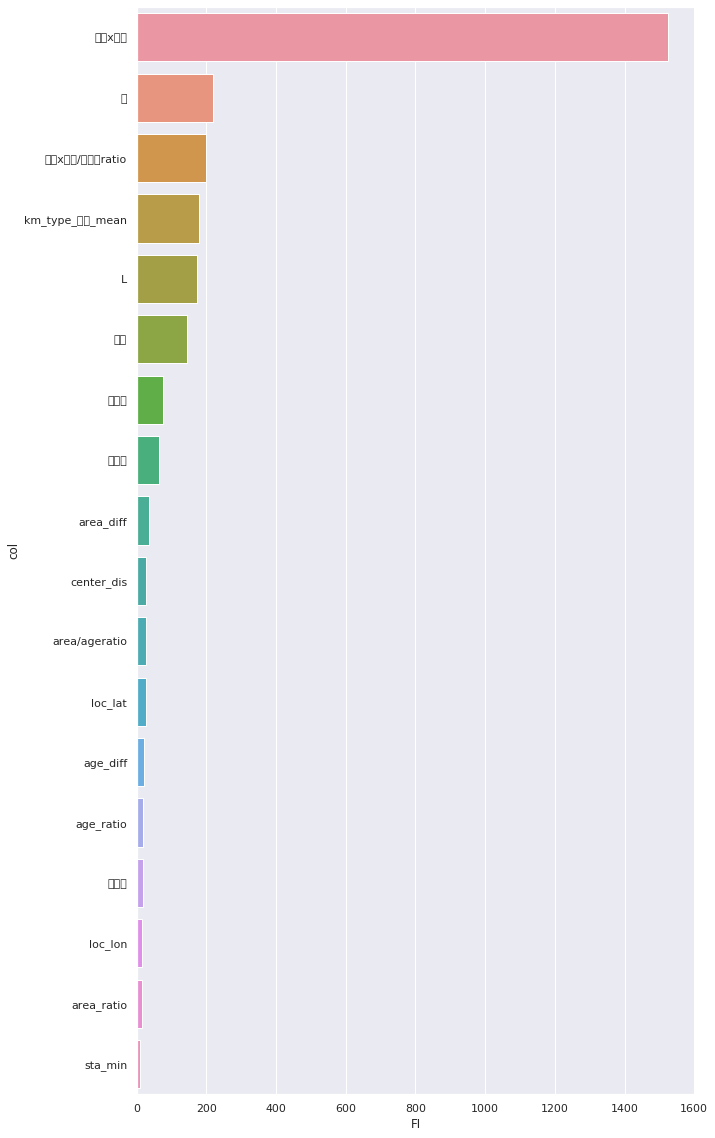

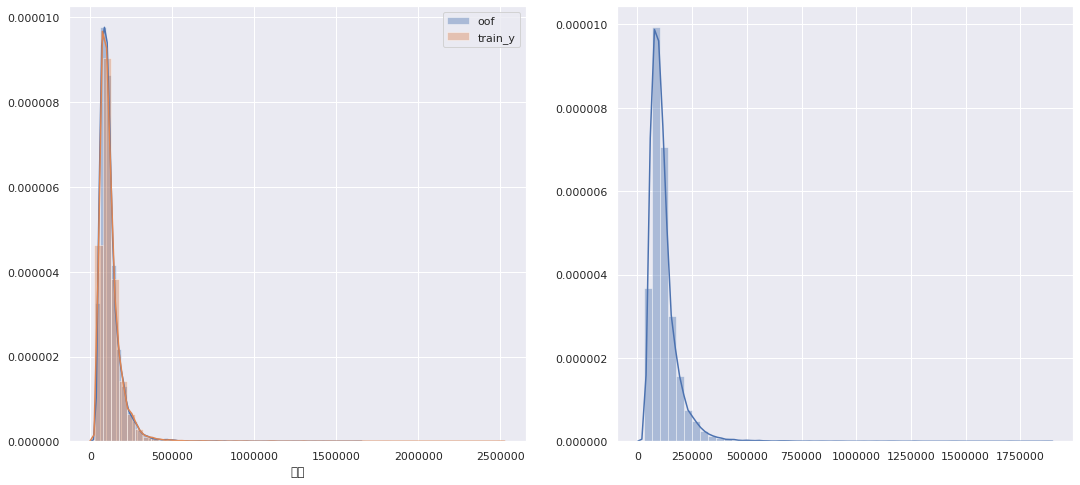

RMSE :  15980.857613712067
R^2 :  0.9483328896388196


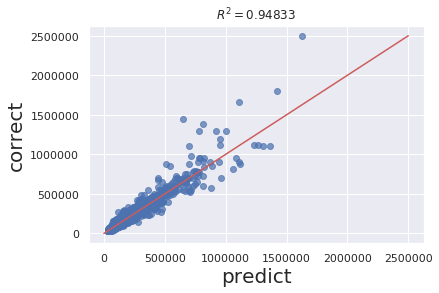

In [284]:
xent_func= lambda x:np.log1p(x)/np.log1p(x.max())
xent_refunc= lambda x:np.expm1(x*14.731801689838349)

XLGBM = LogRegressionPredictor(X_train, y_train, X_test, Folder=folder, params=lgbm_x_params,
                                      sk_model=None, n_splits=10, clf_type='lgb',func=xent_func,revert_func=xent_refunc)
xlgboof, xlgbpreds, xlgbFIs = XLGBM.fit()
XLGBM.plot_FI(50)
XLGBM.plot_pred_dist()
XLGBM.plot_scatter_oofvspred()

### normal_predict

In [288]:
XLGBM.rmse()

15980

In [291]:
import pandas as pd
from pathlib import Path
import datetime

In [305]:
save_data(X_train,xlgboof, xlgbpreds,rmse=XLGBM.rmse(),name='xent_tika_km_col',save_dir='./stacking')

,id,target
0,31471,131716.898689
1,31472,118144.969809
2,31473,75672.612840
3,31474,61398.192711
4,31475,97812.009639


,id,target
0,1,81858.142987
1,2,58915.926401
2,3,109344.784345
3,4,175971.414982
4,5,62708.364295


Training on fold 1
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3228]	training's rmse: 10520.7	valid_1's rmse: 16163.1
Training on fold 2
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2295]	training's rmse: 11170.5	valid_1's rmse: 19069.4
Training on fold 3
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1337]	training's rmse: 13211.7	valid_1's rmse: 15743.8
Training on fold 4
Training until validation scores don't improve for 50 rounds.
[5000]	training's rmse: 9196.2	valid_1's rmse: 13381.4
Early stopping, best iteration is:
[7242]	training's rmse: 7963.33	valid_1's rmse: 13018.1
Training on fold 5
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1387]	training's rmse: 12914	valid_1's rmse: 19241.7
Training on fold 6
Training until validation scores don't improve for 50 rounds.
Early 

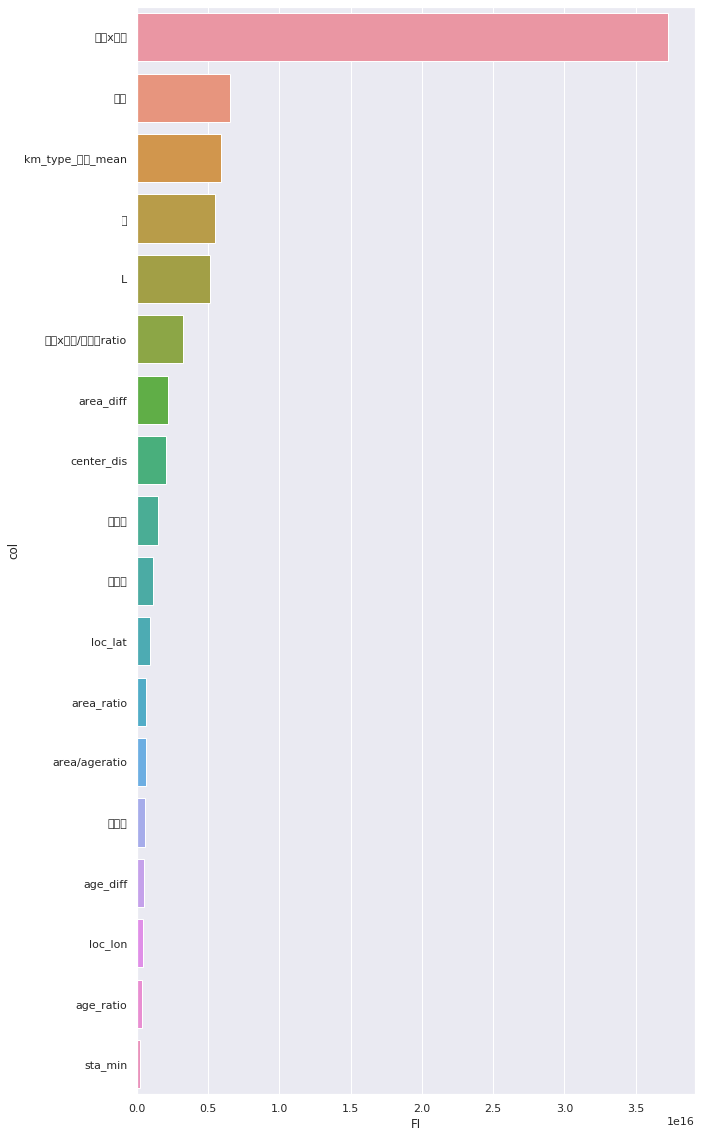

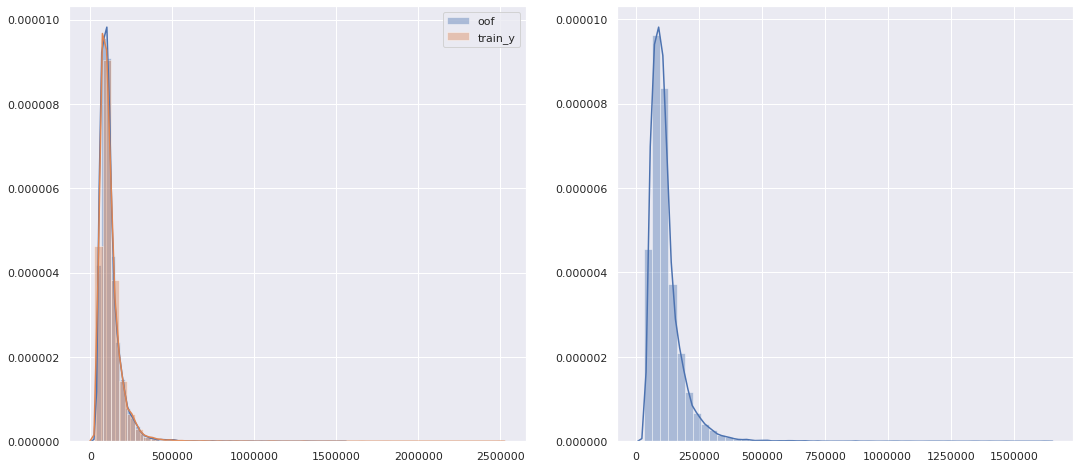

RMSE :  17143.949959276906
R^2 :  0.9411925923602866


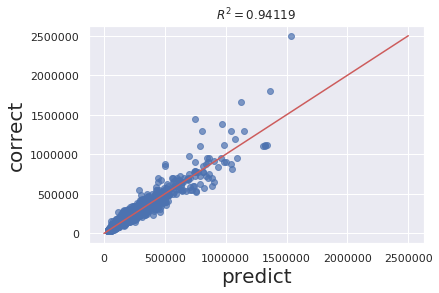

In [306]:
LGBM = RegressionPredictor(X_train, y_train.values, X_test, Folder=folder, params=lgbm_params,
                                      sk_model=None, n_splits=10, clf_type='lgb')
lgboof, lgbpreds, lgbFIs = LGBM.fit()
LGBM.plot_FI(50)
LGBM.plot_pred_dist()
LGBM.plot_scatter_oofvspred()

In [308]:
save_data(X_train,lgboof, lgbpreds,rmse=LGBM.rmse(),name='tika_kmcol',save_dir='./stacking')

,id,target
0,31471,134378.682255
1,31472,113087.628161
2,31473,72532.107663
3,31474,63063.236768
4,31475,118650.740952


,id,target
0,1,81965.541979
1,2,66042.822173
2,3,103919.686359
3,4,168036.605376
4,5,71642.266041


### log_predict

Training on fold 1
Training until validation scores don't improve for 50 rounds.
[5000]	training's l1: 0.0207161	valid_1's l1: 0.054144
Early stopping, best iteration is:
[7935]	training's l1: 0.0134119	valid_1's l1: 0.05242
Training on fold 2
Training until validation scores don't improve for 50 rounds.
[5000]	training's l1: 0.020777	valid_1's l1: 0.0532555
[10000]	training's l1: 0.01037	valid_1's l1: 0.0506887
[15000]	training's l1: 0.0061603	valid_1's l1: 0.0497888
Early stopping, best iteration is:
[15443]	training's l1: 0.00592369	valid_1's l1: 0.0497357
Training on fold 3
Training until validation scores don't improve for 50 rounds.
[5000]	training's l1: 0.0208308	valid_1's l1: 0.0544564
[10000]	training's l1: 0.010361	valid_1's l1: 0.0516133
Early stopping, best iteration is:
[12293]	training's l1: 0.00799789	valid_1's l1: 0.0510669
Training on fold 4
Training until validation scores don't improve for 50 rounds.
[5000]	training's l1: 0.0209751	valid_1's l1: 0.0556742
[10000]	tra

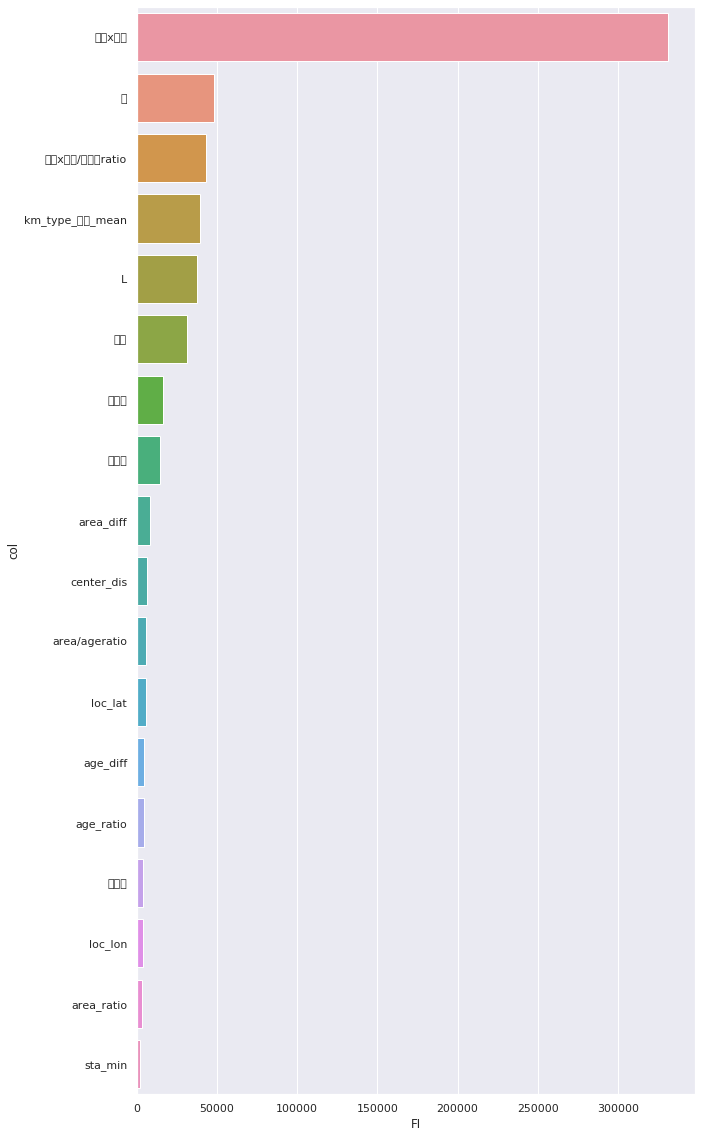

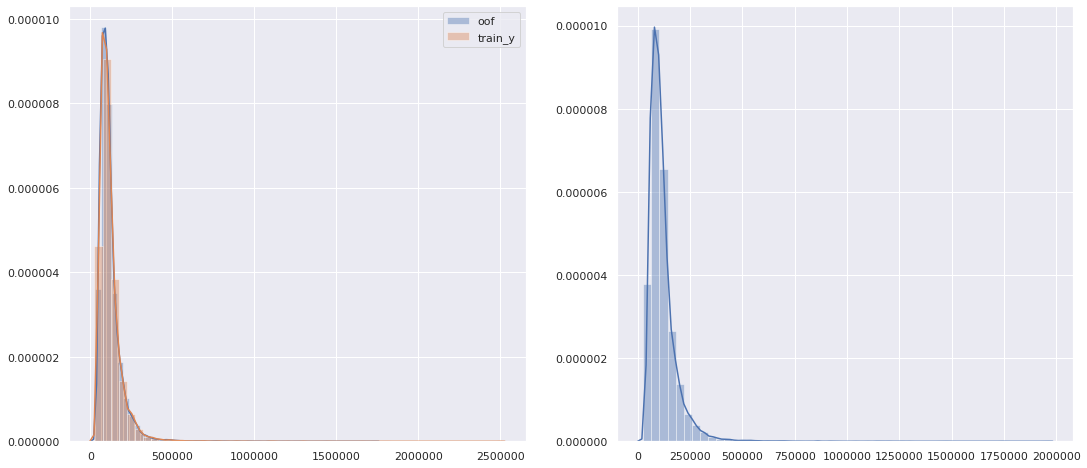

RMSE :  15730.21547113888
R^2 :  0.9499357284558583


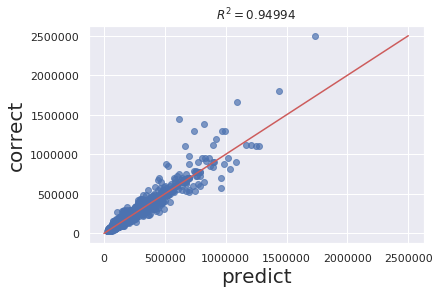

In [309]:
LogLGBM = LogRegressionPredictor(X_train, y_train.values, X_test, Folder=folder, params=lgbm_log_params,
                                      sk_model=None, n_splits=10, clf_type='lgb')
log_lgboof, log_lgbpreds, log_lgbFIs = LogLGBM.fit()
LogLGBM.plot_FI(50)
LogLGBM.plot_pred_dist()
LogLGBM.plot_scatter_oofvspred()

In [311]:
save_data(X_train,log_lgboof, log_lgbpreds,rmse=LGBM.rmse(),name='log_tika_km_col',save_dir='./stacking')

,id,target
0,31471,132617.456514
1,31472,119327.592929
2,31473,74851.570913
3,31474,60325.833901
4,31475,93832.804783


,id,target
0,1,83100.383234
1,2,56473.838404
2,3,110128.704218
3,4,178391.802192
4,5,63512.945628
